<a href="https://colab.research.google.com/github/amina01/Learning-Neural-Activations/blob/master/Smoothness_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 1000/1000 [00:12<00:00, 79.29it/s]


learnable parameters= 402


Text(0, 0.5, 'g(z)')

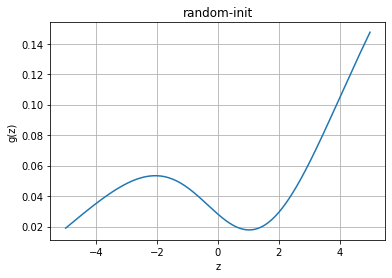

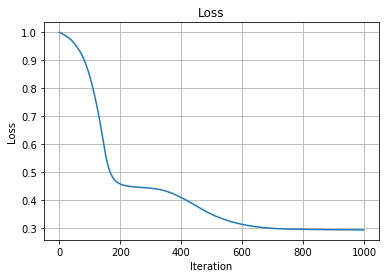

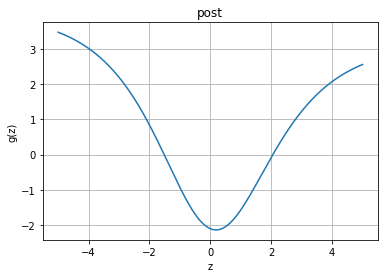

In [3]:
# Smoothness analysis over random networks
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
from sklearn.metrics import roc_auc_score as auc_roc
import itertools
import warnings
from tqdm import tqdm

def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params 

class AF(nn.Module):
    def __init__(self):
        super(AF, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        

        z = x.shape
        x = x.flatten().unsqueeze(1)
        
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        
        return x.view(z)


class Net(nn.Module):
    def __init__(self,d):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(d,4)  
        self.out = nn.Linear(4,1)
        self.act1 = AF()
        

    def forward(self,x):
        x = self.hidden1(x)
        x1= self.act1(x)
        x = self.out(x1)
        return x1,x






def hinge(y_true, y_pred):
    zero = torch.Tensor([0]) 
    return torch.max(zero, 1 - y_true * y_pred)

###################Generate Data######################
d=1.50
n=500
X1=np.random.randn(n,2)+d*np.array([1,1])
l1=[1.0]*len(X1)

X2=np.random.randn(n,2)+d*np.array([1,-1])
l2=[-1.0]*len(X2)

X3=np.random.randn(n,2)+d*np.array([-1,1])
l3=[-1.0]*len(X3)


X4=np.random.randn(n,2)+d*np.array([-1,-1])
l4=[1.0]*len(X4)

data=np.vstack((X1, X2, X3, X4))
labels=np.array(l1+l2+l3+l4)

Xtr=Variable(torch.from_numpy(data)).type(torch.FloatTensor)

Ytr=Variable(torch.from_numpy(labels)).type(torch.FloatTensor)




############## Train classifier#########################

class_epochs=1000
mlp_class=Net(Xtr.shape[1])


#Plot AFU before training
plt.figure();z = torch.linspace(-5,5,1000); 
plt.plot(z.numpy(),mlp_class.act1(z.unsqueeze(-1)).detach().numpy());
plt.grid(); plt.title("random-init"); plt.xlabel('z'); plt.ylabel('g(z)')



optimizer = optim.Adam(mlp_class.parameters(), lr=0.001)
L=[]

for epoch in tqdm(range(class_epochs)):
            # Forward pass: Compute predicted y by passing x to the model

    h = torch.squeeze(mlp_class(Xtr)[-1],1)

    loss=torch.mean(hinge(Ytr,h)) 
  
    L.append(loss.data.numpy())

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()


plt.figure()
plt.plot(L)
plt.title('Loss')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')    
    


print ('learnable parameters=', count_parameters(mlp_class))

for param in mlp_class.parameters():
    param.requires_grad =False

#Plot AFU after training
plt.figure();z = torch.linspace(-5,5,1000); 
plt.plot(z.numpy(),mlp_class.act1(z.unsqueeze(-1)).detach().numpy());
plt.grid(); plt.title("post"); plt.xlabel('z'); plt.ylabel('g(z)')        



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: The following kwargs were not used by contour: 'label'


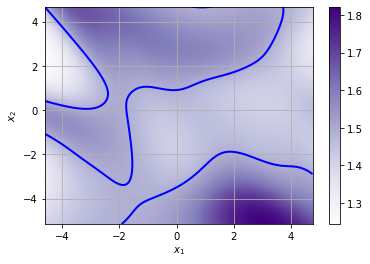

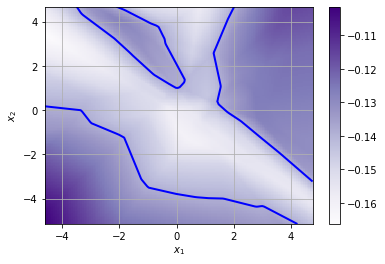

[-4.614727066589356, 4.759719894958496, -5.144710587097168, 4.6863422857055665]

In [4]:
def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)        
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:            
            conts = sorted([-1+eps,0,1-eps])
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)
        
        z = np.reshape(z,(npts,npts)).T        
        
        conts=sorted([np.median(z)])
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=np.min(z),vmax=np.max(z));plt.colorbar()
        plt.axis(extent)
    
    if Y is not None:        
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()
    return extent


class RandomNetAF(nn.Module):
    def __init__(self,d, af):
        super(RandomNetAF, self).__init__()
        self.hidden1 = nn.Linear(2,d)  
        self.hidden2 = nn.Linear(d,d) 
        self.hidden3 = nn.Linear(d,d) 
        self.hidden4 = nn.Linear(d,d)  
        self.out = nn.Linear(d,1)
        self.act1 = af
        
        

    def forward(self,x):
        x = self.hidden1(x)
        x= self.act1(x)
        x=self.hidden2(x)
        x=self.act1(x)   
        x=self.hidden3(x)
        x=self.act1(x)
        x=self.hidden4(x)
        x=self.act1(x)     
        x = self.out(x)
         
        return x


seed=100
torch.manual_seed(seed)
d=10
rAF=RandomNetAF(d, mlp_class.act1)

torch.manual_seed(seed)
rReLU=RandomNetAF(d, torch.relu)

for param in rAF.parameters():
    param.requires_grad =False
     
for param in rReLU.parameters():
    param.requires_grad =False
    
X=Xtr
Y=Ytr


plt.figure()
X2=np.array(X)


def clf_final(X):
    X=Variable(torch.from_numpy(X)).type(torch.FloatTensor)
    z=rAF(X)
    z=z.numpy()
    return z
plotit(X2,Y,clf=clf_final, transform = None, conts =[-1,0,1])

plt.figure()

def clf_final2(X):
    X=Variable(torch.from_numpy(X)).type(torch.FloatTensor)
    z=rReLU(X)
    z=z.numpy()
    return z

plotit(X2,Y,clf=clf_final2, transform = None, conts =[-1,0,1])